In [160]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import ml4gw
from matplotlib import cm, colors, colormaps
from utils.preprocessing import PsdEstimator
from ml4gw.distributions import PowerLaw
waveform_path = '/home/seiya.tsukamoto/aframe/layered/data/train/training_waveforms/waveforms-0.hdf5'
background_path = '/home/seiya.tsukamoto/aframe/layered/data/train/background/background-1240579783-7829.hdf5'
import sys
from train.augmentations import WaveformProjector
from ml4gw.distributions import Cosine
from torch.distributions.uniform import Uniform
from ml4gw.utils.slicing import sample_kernels
import torch
sys.path.append('/cvmfs/software.igwn.org/conda/envs/igwn/lib/python3.10/site-packages/gwpy/')
dec_space = Cosine()
psi_space = Uniform(0, np.pi)
phi_space = Uniform(-np.pi, np.pi)
projector = WaveformProjector(['H1', 'L1'], 2048)
from train.waveform_sampler import (
    ChunkedWaveformDataset,
    Hdf5WaveformLoader,
    WaveformSampler,
)

In [224]:
psd_estimator = PsdEstimator(3.75,
            2048,
            3.75,
            window=None,
            fast=True,
            average="median",
        )
whitener = Whiten(1,2048,32,1024)
snr_sampler=PowerLaw(minimum = 300, maximum = 310, index = -3)
waveform_sampler = WaveformSampler()

In [270]:
with h5py.File(waveform_path, 'r') as f:
    waveforms = f['waveforms']['cross'][:201], f['waveforms']['plus'][:201]
waveforms = np.stack(waveforms, axis = 1)
with h5py.File(background_path, 'r') as f:
    bg = f['H1'][20480:20480+20480]
bg = torch.tensor(bg)
waveforms = torch.tensor(waveforms)
bg = bg.unsqueeze(dim = 0).unsqueeze(dim = 0).repeat(201, 2, 1)

bg, psds = psd_estimator(bg)
*params, polarizations, mask = waveform_sampler(bg, 1, waveforms)
N = len(waveforms)
snrs = snr_sampler.sample((N,)).to(X.device)
dec = dec_space.sample((N,))
psi = psi_space.sample((N,))
phi = phi_space.sample((N,))
responses = projector(dec, psi, phi, snrs, psds, **polarizations)
X = bg + responses[..., int((8.1-3.75)*2048):int(8.1*2048)]
whitened_X = whitener(X, psds)

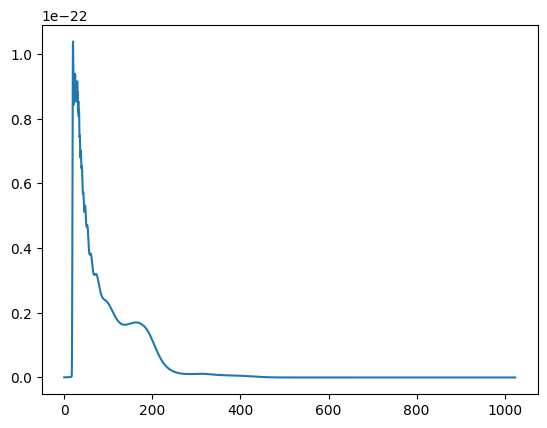

In [274]:
from scipy.fft import fft, fftfreq
import numpy as np
N = int(2.75*2048)
T = 1.0 / 2048
yf = fft(responses[0, 0, int((8.1-2.75)*2048):int(8.1*2048)])
out = 2.0/N * np.abs(yf[0:N//2])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, out)

In [271]:
from ml4gw.transforms import QScan
from ml4gw.transforms import Whiten

In [275]:
qs = QScan(duration = 3.75, sample_rate = 2048, spectrogram_shape = [256, 512], qrange = [8, 12], frange = [32, 512])

In [279]:
time_freq = qs(whitened_X[1][0])

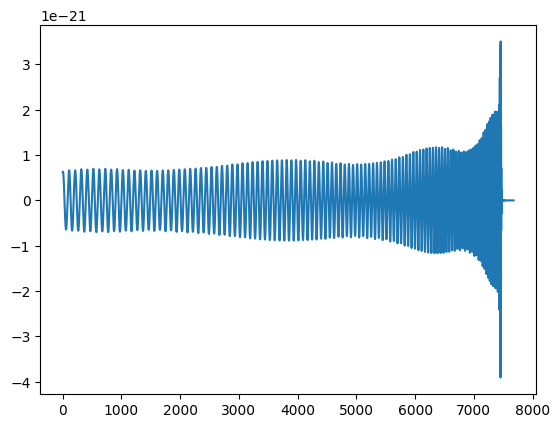

In [283]:
plt.plot(responses[1, 0, int((8.1-3.75)*2048):int(8.1*2048)])

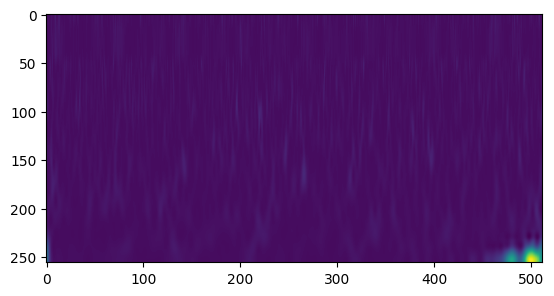

In [284]:
plt.imshow(np.flip(time_freq.numpy(), axis = 0))

In [ ]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 1024
T = 1.0 / 2048
space = np.arange(4.5, 8.25, .25)
out = np.zeros((len(space), 512))
for i in range(len(kernels)):
    for j in range(2):
        for k, t0 in enumerate(space):
            yf = fft(kernels[i][j][int((t0-.25)*2048):int((t0+.25)*2048)])
            out[k] += 2.0/N * np.abs(yf[0:N//2])

4.5 /pm 0.25
4.75 /pm 0.25
5.0 /pm 0.25
5.25 /pm 0.25
5.5 /pm 0.25
5.75 /pm 0.25
6.0 /pm 0.25
6.25 /pm 0.25
6.5 /pm 0.25
6.75 /pm 0.25
7.0 /pm 0.25
7.25 /pm 0.25
7.5 /pm 0.25
7.75 /pm 0.25
8.0 /pm 0.25


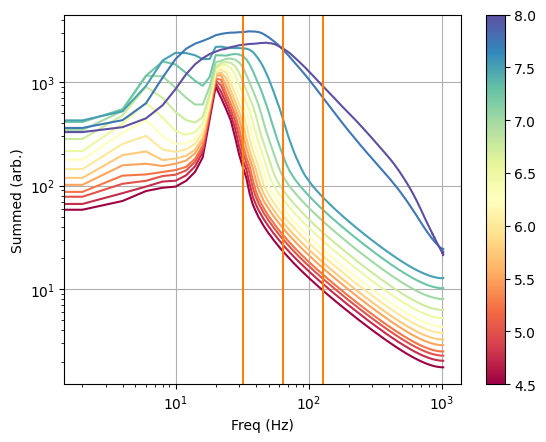

In [5]:
xf = fftfreq(N, T)[:N//2]
cmap = colormaps["Spectral"]
norm = colors.Normalize(min(space), max(space))
fig, ax = plt.subplots()
for k, t0 in enumerate(space):
    print(f'{t0} /pm {.25}')
    ax.plot(xf, out[k], color = cmap(norm(t0)))
ax.set_xscale('log')
ax.set_yscale('log')
#plt.axvline(20, c = 'C1')
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.axvline(128, c = 'C1')
plt.xlabel('Freq (Hz)')
plt.ylabel('Summed (arb.)')
#plt.text(13, .9, '16') 
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax)
plt.grid()
plt.show()

In [4]:
import gwpy.timeseries
import gwpy.spectrogram

/home/seiya.tsukamoto/.local/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/usr/local/lib/python3.10/site-packages/ligo/lw/ligolw.py:426: DeprecationWarning: invalid escape sequence '\Z'
  """


In [5]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 1024
T = 1.0 / 2048
space = np.arange(4.5, 8.25, .25)
out = np.zeros((len(space), 512))
ts = gwpy.timeseries.TimeSeries(kernels[-1][0][int(4.1*2048):int(8.1*2048)], sample_rate=2048)
sg = ts.spectrogram(stride = .05)
for i in range(200):
    print(i)
    for j in range(2):
        for k, t0 in enumerate(space):
            ts = gwpy.timeseries.TimeSeries(kernels[i][j][int(4.1*2048):int(8.1*2048)], sample_rate=2048)
            sg += ts.spectrogram(stride = .05)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


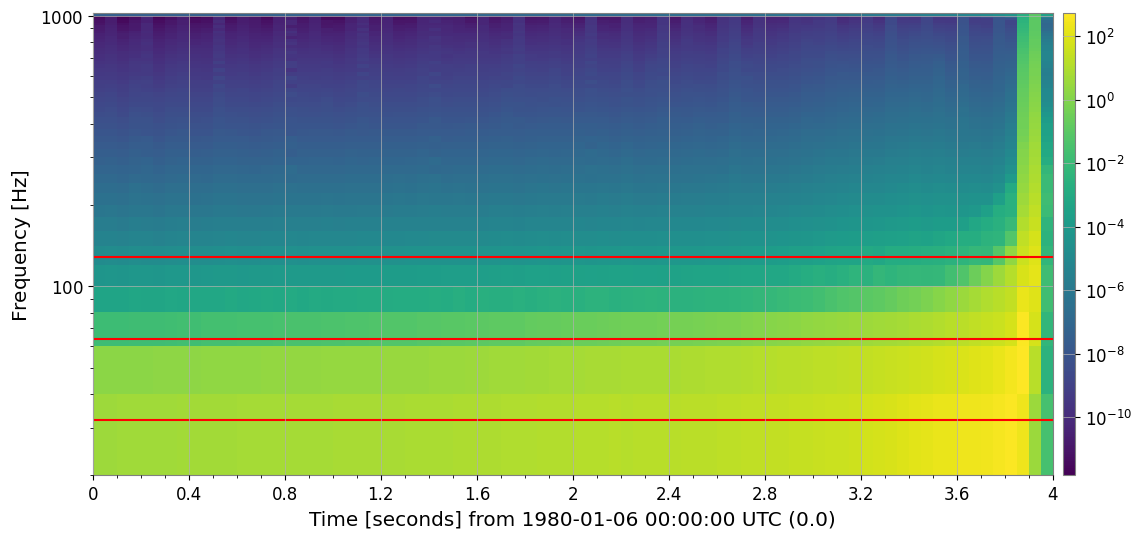

In [6]:
plot = sg.plot(yscale = 'log', ylim = (20, 1024), norm=colors.LogNorm())
plot.show()
plt.plot([0, 4], [32, 32], c = 'r')
plt.plot([0, 4], [64, 64], c = 'r')
plt.plot([0, 4], [128, 128], c = 'r')
plot.colorbar()
plt.savefig('./spectrogram_200waveforms.png')

In [ ]:
1